学習と予測をやってみる

参考になりそうなサイト  
Prior and Posterior Predictive Checks  
https://docs.pymc.io/notebooks/posterior_predictive.html  
    
PyStan / PyMC3 でベイズ統計モデリング  
https://qiita.com/0NE_shoT_/items/2b41ae3e8e8f2d8809c4

GLM in PyMC3: Out-Of-Sample Predictions  
https://juanitorduz.github.io/glm_pymc3/

# Prior and Posterior Predictive Checks

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

from scipy.special import expit as logistic

RANDOM_SEED = 58

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
print(f"Running on PyMC3 v{pm.__version__}")
pm.__version__

Running on PyMC3 v3.11.2


'3.11.2'

In [3]:
az.style.use("arviz-darkgrid")


def standardize(series):
    """Standardize a pandas series"""
    return (series - series.mean()) / series.std()

# 線形モデルの設定

PyMC3チュートリアルの$predictor$、$outcome$ではわかりにくいので、$x$, $y$ で表すことにする。

$\mu = a + b x$  
$y - \mu = y - (a + bx) \sim N(0, \sigma)$

In [4]:
N = 100

# numpyの乱数シード固定
np.random.seed(seed=RANDOM_SEED)
true_a, true_b, x = 0.5, 3.0, np.random.normal(loc=2, scale=6, size=N)
true_mu = true_a + true_b * x
true_sd = 2.0


np.random.seed(seed=RANDOM_SEED+1)
y = np.random.normal(loc=true_mu, scale=true_sd, size=N)

f"{x.mean():.2f}, {x.std():.2f}, {y.mean():.2f}, {y.std():.2f}"

'2.42, 5.84, 7.74, 17.39'

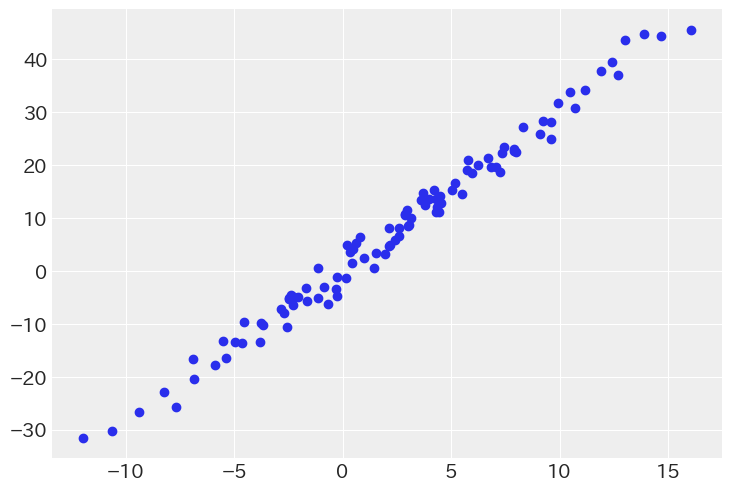

In [5]:
plt.scatter(x, y)

# 前処理

標準化する。  
以下の記事にある通り、前処理で標準化したほうが、収束が早くなるなど実用的にはメリットがあるようだ。
https://gaiasky.hatenablog.com/entry/2018/08/18/204331

In [6]:
x_scaled = standardize(x)
y_scaled = standardize(y)

f"{x_scaled.mean():.2f}, {x_scaled.std():.2f}, {y_scaled.mean():.2f}, {y_scaled.std():.2f}"

'0.00, 1.00, -0.00, 1.00'

Text(0, 0.5, 'y_scaled')

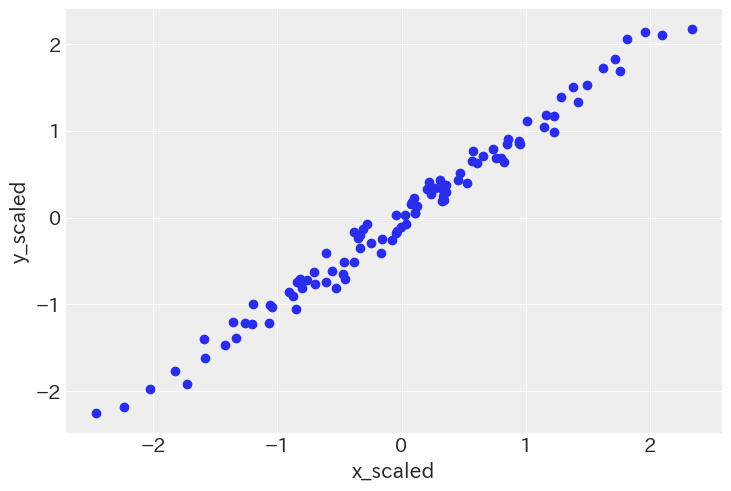

In [7]:
plt.scatter(x_scaled, y_scaled)
plt.xlabel('x_scaled')
plt.ylabel('y_scaled')

In [8]:
with pm.Model() as model_1:
    #a,bの事前分布
    a = pm.Normal("a", 0.0, 10.0)
    b = pm.Normal("b", 0.0, 10.0)

    mu = a + b * x_scaled

    #sigmaの事前分布
    sd = pm.Exponential("sd", 1.0)

    y_obs = pm.Normal("obs", mu=mu, sigma=sd, observed=y_scaled)

    #Prior Predictive Check
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

In [9]:
prior_checks

{'a': array([ -7.60186146, -21.01584011,  -8.09756685,  -0.07517259,
        -17.04360767,   5.81403976,  -9.6914406 , -14.80901103,
         -5.23342546,  12.67064599,   1.72412943, -12.27156377,
         -7.10830245,   9.95168984, -13.14170358,   9.86987528,
         -4.73583206,  -7.43761641,  15.2516944 ,  21.08847752,
         -6.10250409,   3.683563  , -16.13242677,   1.00140688,
        -23.27469986,   1.00818501, -11.05502154, -18.986511  ,
         18.38651172,  14.49940961,  12.02401761,   1.47779132,
         -4.44474193,  -2.29715606, -11.58366798,   6.57029788,
         -3.7449904 ,  11.83904125,   6.30677442,   2.70872653,
          3.93468412,   1.63458036,   0.69283836,   4.19574711,
         -2.72824269,   0.32817574,   5.0940876 ,   3.31872655,
         14.13544801,  19.78035879]),
 'b': array([  1.77235681,   8.73206665,   4.18119134,  13.205115  ,
         -7.82146742,  17.39095094,  -7.47681272,  -9.45493719,
          7.84875346,  -3.7914236 ,  -9.59372576,   0.23

Text(0.5, 1.0, 'Prior predictive checks -- Flat priors')

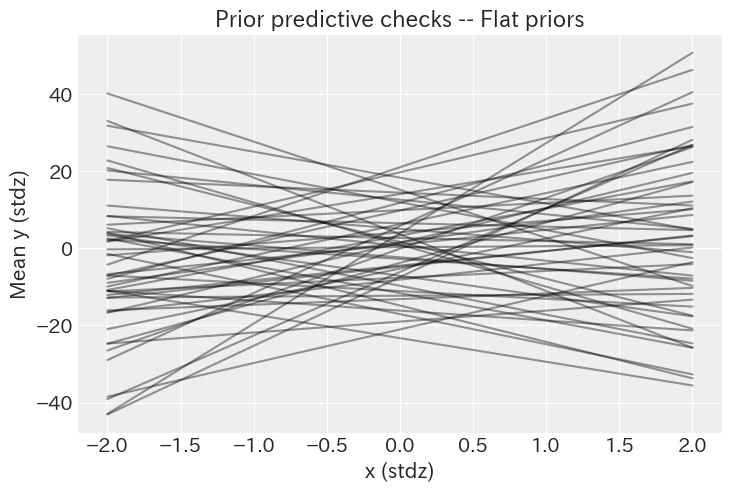

In [10]:
_, ax = plt.subplots()

xx = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["a"], prior_checks["b"]):
    yy = a + b * xx
    ax.plot(xx, yy, c="k", alpha=0.4)

ax.set_xlabel("x (stdz)")
ax.set_ylabel("Mean y (stdz)")
ax.set_title("Prior predictive checks -- Flat priors")

↑前処理した標準化後のxとyのプロットと比較して、yが $O(10)$ 大きい。  
標準化しているのに、$a$と$b$の事前分布に設定した標準偏差が大きすぎることが原因。

In [11]:
with pm.Model() as model_1:
    a = pm.Normal("a", 0.0, 0.5)
    b = pm.Normal("b", 0.0, 1.0)

    mu = a + b * x_scaled
    sd = pm.Exponential("sd", 1.0)

    y_obs = pm.Normal("obs", mu=mu, sigma=sd, observed=y_scaled)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

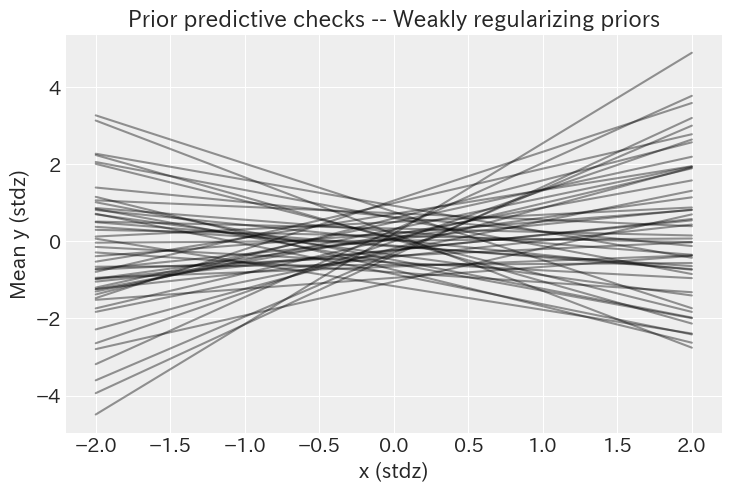

In [12]:
_, ax = plt.subplots()

xx = np.linspace(-2, 2, 50)

for a, b in zip(prior_checks["a"], prior_checks["b"]):
    yy = a + b * xx
    ax.plot(xx, yy, c="k", alpha=0.4)

ax.set_xlabel("x (stdz)")
ax.set_ylabel("Mean y (stdz)")
ax.set_title("Prior predictive checks -- Weakly regularizing priors");

In [13]:
%%time
with model_1:
    trace_1 = pm.sample(1000,#The number of samples to draw
                        tune=2000, #Number of iterations to tune 
                        random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 22 seconds.


Wall time: 26.1 s


In [14]:
trace_1

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

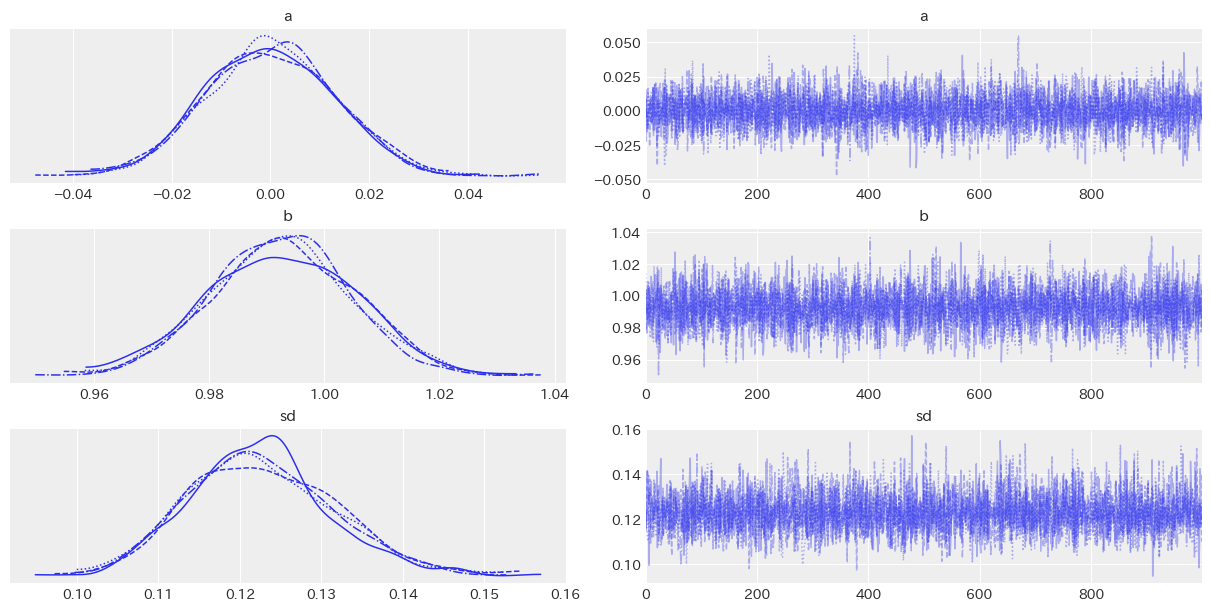

In [15]:
with model_1:
    az.plot_trace(trace_1);

## Posterior Predictive Check

In [16]:
with model_1:
    ppc = pm.sample_posterior_predictive(
        trace_1, var_names=["a", "b", "obs"], random_seed=RANDOM_SEED
    )

In [17]:
ppc

{'a': array([ 0.00906085,  0.00906085, -0.01311617, ..., -0.00358266,
         0.02097386, -0.00807652]),
 'b': array([1.00402775, 1.00402775, 0.97669603, ..., 0.99921514, 0.99016328,
        0.98857942]),
 'obs': array([[-0.93526096, -2.47497817, -0.99216026, ...,  0.74686846,
          0.64722702,  0.96148101],
        [-0.82473667, -2.3012839 , -1.11214872, ...,  0.77173141,
          0.42654421,  0.91988314],
        [-0.92053443, -2.35452763, -0.98919393, ...,  0.57242611,
          0.52218358,  0.85244842],
        ...,
        [-0.65476626, -2.24861814, -0.72027506, ...,  0.59218946,
          0.83636872,  0.69786998],
        [-0.77355304, -2.02814827, -0.93242986, ...,  0.71056829,
          0.72376059,  0.7323784 ],
        [-0.75596237, -2.17708862, -0.97040804, ...,  0.76065347,
          0.54928183,  1.00711479]])}

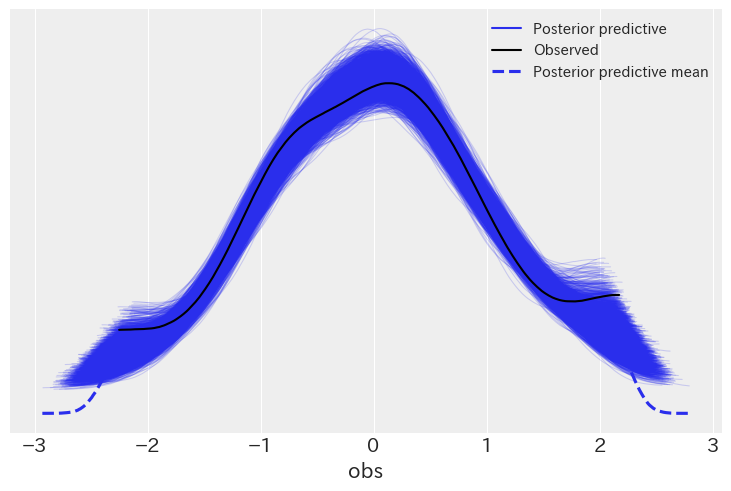

In [18]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model_1));

↑上のPosterior Predictiveにはsdがパラメータとして入っていない気がする。念のためsdも入れてやってみる。

In [19]:
with model_1:
    ppc = pm.sample_posterior_predictive(
        trace_1, var_names=["a", "b", "sd", "obs"], random_seed=RANDOM_SEED
    )

In [20]:
ppc

{'a': array([ 0.00906085,  0.00906085, -0.01311617, ..., -0.00358266,
         0.02097386, -0.00807652]),
 'b': array([1.00402775, 1.00402775, 0.97669603, ..., 0.99921514, 0.99016328,
        0.98857942]),
 'sd': array([0.11660956, 0.11660956, 0.14116699, ..., 0.12223798, 0.12716923,
        0.11649287]),
 'obs': array([[-0.93526096, -2.47497817, -0.99216026, ...,  0.74686846,
          0.64722702,  0.96148101],
        [-0.82473667, -2.3012839 , -1.11214872, ...,  0.77173141,
          0.42654421,  0.91988314],
        [-0.92053443, -2.35452763, -0.98919393, ...,  0.57242611,
          0.52218358,  0.85244842],
        ...,
        [-0.65476626, -2.24861814, -0.72027506, ...,  0.59218946,
          0.83636872,  0.69786998],
        [-0.77355304, -2.02814827, -0.93242986, ...,  0.71056829,
          0.72376059,  0.7323784 ],
        [-0.75596237, -2.17708862, -0.97040804, ...,  0.76065347,
          0.54928183,  1.00711479]])}

<AxesSubplot:xlabel='obs'>

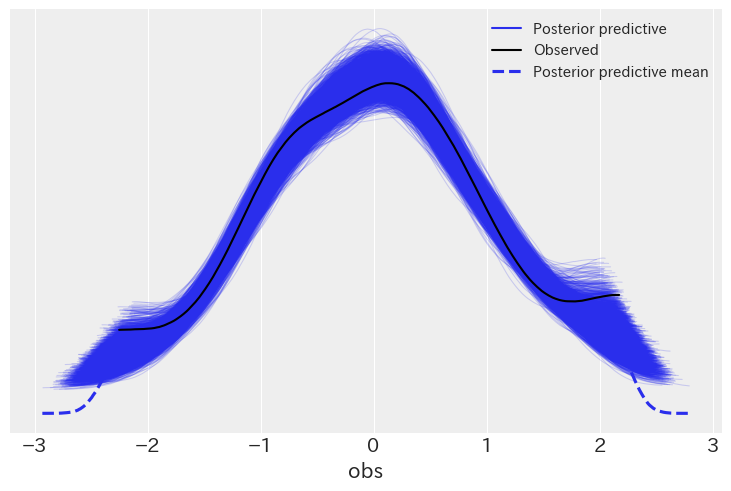

In [21]:
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model_1))

結果はsdを入れてもあまり変わりなし。

plot_hdiなら通る、記事の通りplot_hpdならエラーとなる。バージョンの違いか？

C:\Users\shkom\anaconda3\envs\mypm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
C:\Users\shkom\anaconda3\envs\mypm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


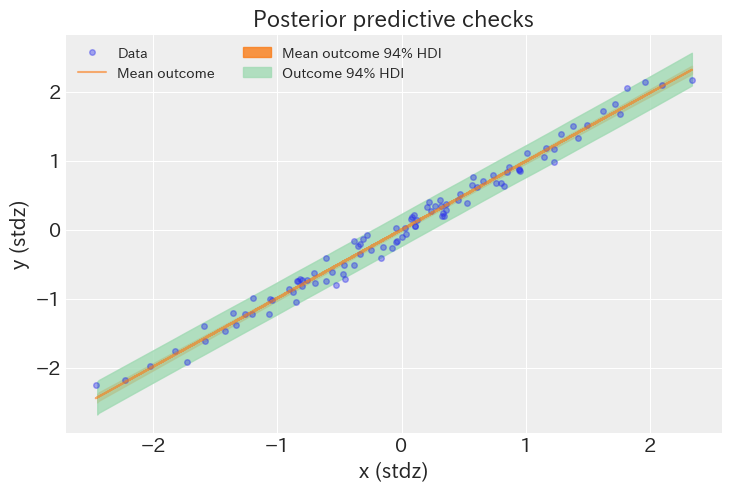

In [22]:
mu_pp = (ppc["a"] + ppc["b"] * x_scaled[:, None]).T

_, ax = plt.subplots()

ax.plot(x_scaled, y_scaled, "o", ms=4, alpha=0.4, label="Data")
ax.plot(x_scaled, mu_pp.mean(0), label="Mean outcome", alpha=0.6)
az.plot_hdi(
    x_scaled,
    mu_pp,
    ax=ax,
    fill_kwargs={"alpha": 0.8, "label": "Mean outcome 94% HDI"},
)
az.plot_hdi(
    x_scaled,
    ppc["obs"],
    ax=ax,
    fill_kwargs={"alpha": 0.8, "color": "#a1dab4", "label": "Outcome 94% HDI"},
)

ax.set_xlabel("x (stdz)")
ax.set_ylabel("y (stdz)")
ax.set_title("Posterior predictive checks")
ax.legend(ncol=2, fontsize=10);

In [23]:
mu_pp.shape

(4000, 100)

## 前処理なしでやってみる

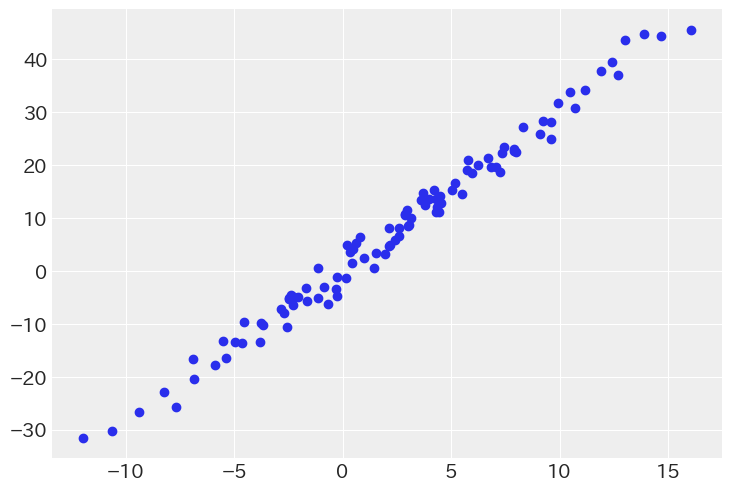

In [24]:
plt.scatter(x,y)

In [25]:
with pm.Model() as model_0:
    a = pm.Normal("a", 0.0, 2.0)
    b = pm.Normal("b", 0.0, 2.0)

    mu = a + b * x
    sd = pm.Exponential("sd", 1.0)

    y_obs = pm.Normal("obs", mu=mu, sigma=sd, observed=y)
    prior_checks = pm.sample_prior_predictive(samples=50, random_seed=RANDOM_SEED)

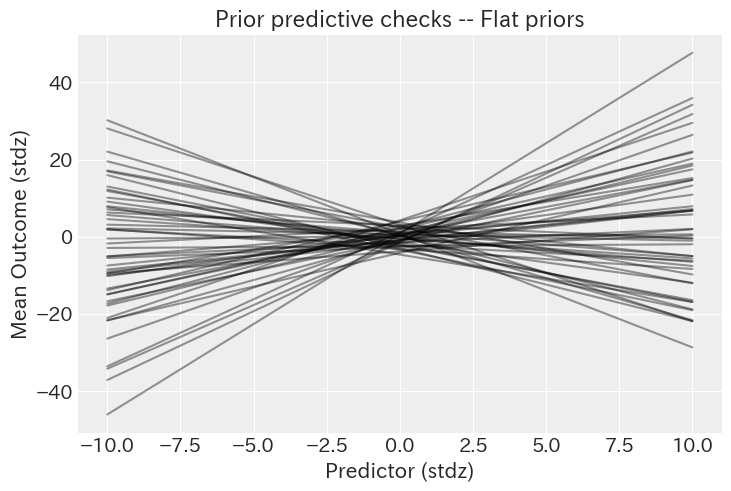

In [26]:
_, ax = plt.subplots()

x = np.linspace(-10, 10, 50)

for a, b in zip(prior_checks["a"], prior_checks["b"]):
    y = a + b * x
    ax.plot(x, y, c="k", alpha=0.4)

ax.set_xlabel("Predictor (stdz)")
ax.set_ylabel("Mean Outcome (stdz)")
ax.set_title("Prior predictive checks -- Flat priors");

In [27]:
%%time
with model_0:
    trace_0 = pm.sample(draws=1000,#The number of samples to draw
                        tune=2000, #Number of iterations to tune 
                        random_seed=RANDOM_SEED, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, b, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 22 seconds.


Wall time: 24.5 s


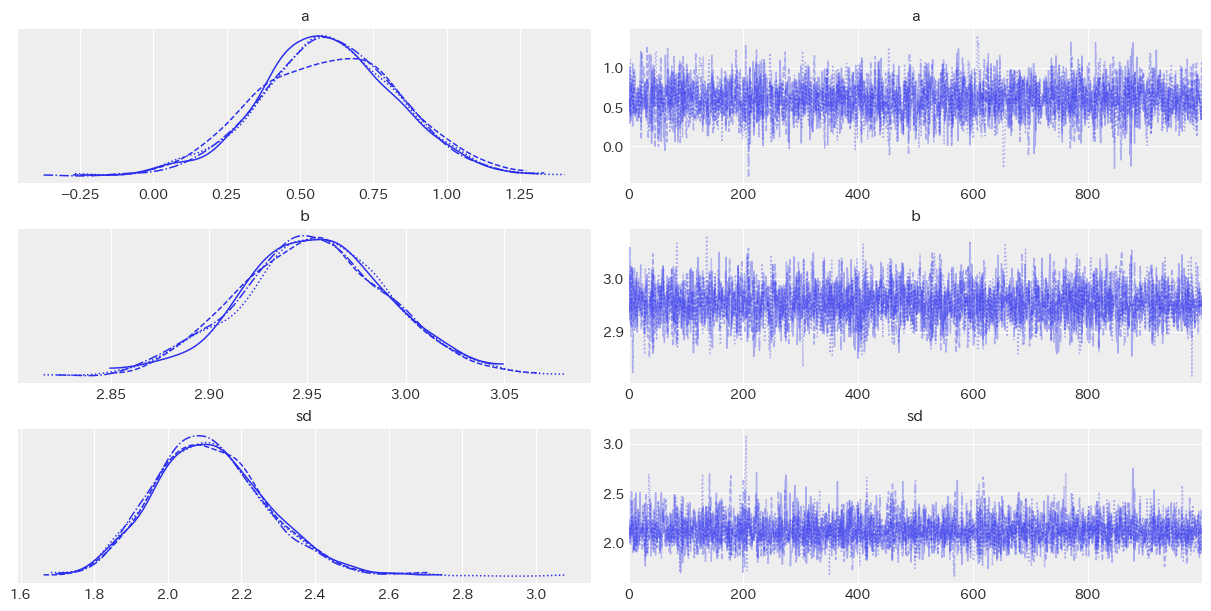

In [28]:
with model_0:
    az.plot_trace(trace_0);

↑標準化しない場合、1秒くらい計算時間が多くかかる。結果は妥当なものが得られている。

# Prediction

Logistic regression model is used.

In [29]:
N = 400
true_intercept = 0.2
true_slope = 1.0

np.random.seed(seed=RANDOM_SEED)
x = np.random.normal(size=N)

true_p = logistic(true_intercept + true_slope * x)

np.random.seed(seed=RANDOM_SEED)
y = np.random.binomial(1, true_p)

y

array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0,

In [30]:
y.sum()/len(y)

0.5175

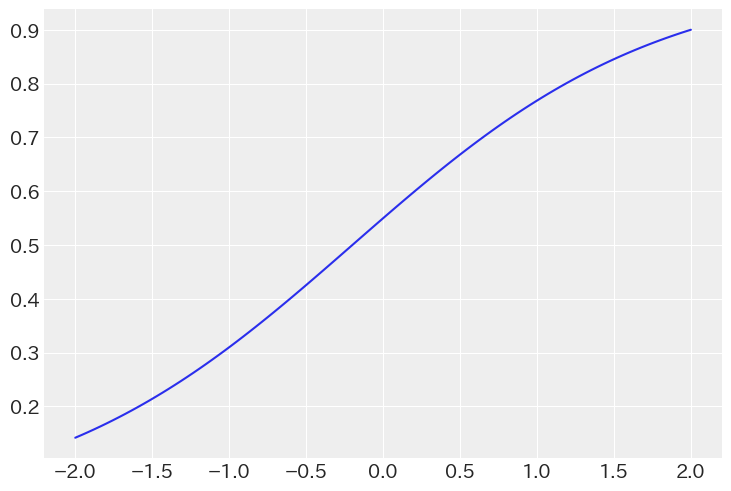

In [31]:
xx = np.linspace(-2,2,100)
yy = logistic(true_intercept + true_slope * xx)
plt.plot(xx,yy)

In [32]:
with pm.Model() as model_2:
    betas = pm.Normal("betas", mu=0.0, sigma=np.array([0.5, 1.0]), shape=2)

    # set predictors as shared variable to change them for PPCs:
    x_data = pm.Data("x_data", x) # pred -> x_data
    p = pm.Deterministic("p", pm.math.invlogit(betas[0] + betas[1] * x_data))
    
    y_pbs = pm.Bernoulli("y_pbs", p=p, observed=y)
    
    trace_2 = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED, return_inferencedata=True)
    
az.summary(trace_2, var_names=["betas"], round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [betas]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 22 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.14,0.11,-0.07,0.34,0.0,0.0,3183.91,2653.16,1.0
betas[1],1.04,0.14,0.79,1.31,0.0,0.0,3039.65,2748.28,1.0


Now, let’s simulate **out-of-sample data**  to see how the model predicts them

In [33]:
x_out_of_sample = np.random.normal(size=50)

y_out_of_sample = np.random.binomial(
    1, logistic(true_intercept + true_slope * x_out_of_sample)
)

with model_2:
    # update values of predictors:
    pm.set_data({"x_data": x_out_of_sample})
    # use the updated values and predict outcomes and probabilities:
    posterior_predictive = pm.sample_posterior_predictive(
        trace_2, var_names=["p"], random_seed=RANDOM_SEED
    )
    model_preds = posterior_predictive["p"]

In [34]:
model_preds.shape

(4000, 50)

4000回のサンプリングを実施して、50個アウトサンプルに対する予測の分布を求めている

In [35]:
az.hdi(model_preds).T

C:\Users\shkom\anaconda3\envs\mypm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


array([[0.11593379, 0.4187348 , 0.40941399, 0.73946141, 0.58757638,
        0.81580311, 0.62780783, 0.2520021 , 0.35713739, 0.45339945,
        0.77057381, 0.17539322, 0.64945269, 0.57211301, 0.44584096,
        0.52585962, 0.87892233, 0.41884182, 0.77390054, 0.79626765,
        0.51058118, 0.39727738, 0.28610973, 0.4986508 , 0.31097355,
        0.71656761, 0.80734145, 0.60995034, 0.60977862, 0.5722449 ,
        0.21710147, 0.40767897, 0.6298943 , 0.56079787, 0.5749199 ,
        0.52178477, 0.71630987, 0.50555499, 0.59680675, 0.52362757,
        0.4176366 , 0.46041233, 0.71721638, 0.68639852, 0.4131032 ,
        0.31052705, 0.60773993, 0.68247914, 0.82527119, 0.75666579],
       [0.24394997, 0.52172571, 0.51360709, 0.86290815, 0.69703582,
        0.92661147, 0.74440277, 0.37513585, 0.4662923 , 0.55455472,
        0.89089358, 0.30623782, 0.76866537, 0.68021101, 0.54740388,
        0.62962078, 0.96562562, 0.52185343, 0.89398334, 0.91170034,
        0.6133259 , 0.50313225, 0.40475349, 0.6

In [36]:
model_preds.mean(0).shape

(50,)

C:\Users\shkom\anaconda3\envs\mypm3env\lib\site-packages\arviz\stats\stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


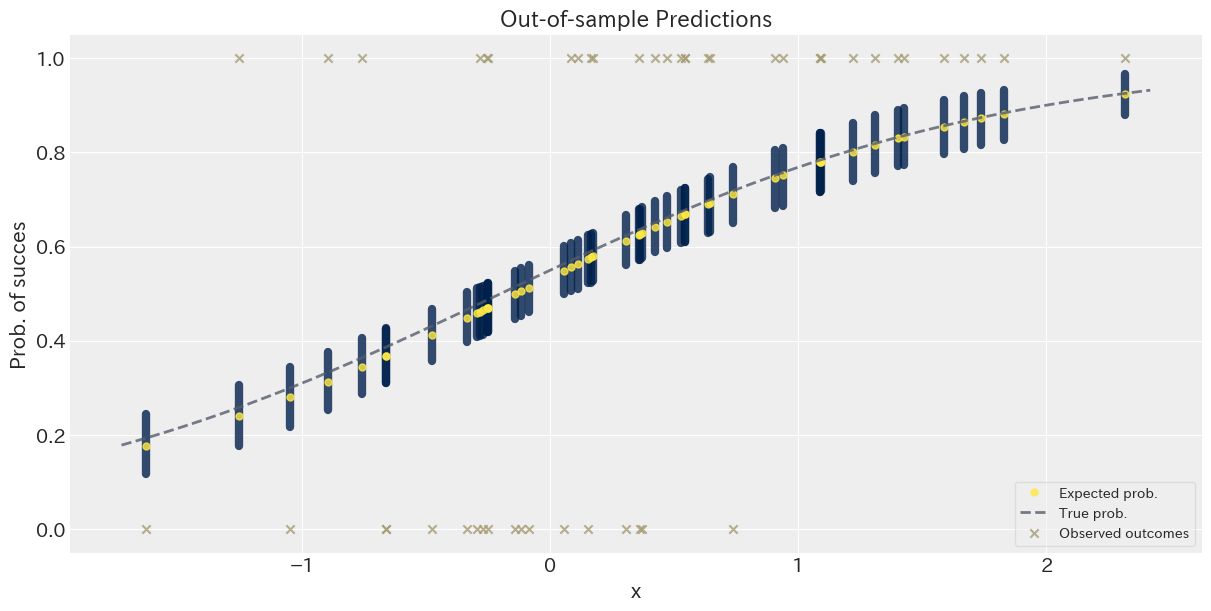

In [38]:
_, ax = plt.subplots(figsize=(12, 6))

# uncertainty about the estimates:
ax.plot(
    [x_out_of_sample, x_out_of_sample],
    az.hdi(model_preds).T,
    lw=6,
    color="#00204C",
    alpha=0.8,
)
# expected probability of success:
ax.plot(
    x_out_of_sample,
    model_preds.mean(0),
    "o",
    ms=5,
    color="#FFE945",
    alpha=0.8,
    label="Expected prob.",
)

# actual outcomes:
ax.scatter(
    x=x_out_of_sample,
    y=y_out_of_sample,
    marker="x",
    color="#A69C75",
    alpha=0.8,
    label="Observed outcomes",
)

# true probabilities:
x = np.linspace(x_out_of_sample.min() - 0.1, x_out_of_sample.max() + 0.1)
ax.plot(
    x,
    logistic(true_intercept + true_slope * x),
    lw=2,
    ls="--",
    color="#565C6C",
    alpha=0.8,
    label="True prob.",
)

ax.set_xlabel("x")
ax.set_ylabel("Prob. of succes")
ax.set_title("Out-of-sample Predictions")
ax.legend(fontsize=10, frameon=True, framealpha=0.5);